# Спортивный анализ данных на платформе Kaggle.
## Курсовой проект. 

Ссылка на соревнование - https://www.kaggle.com/c/geekbrains-competitive-data-analysis/data

Постановка задачи.

Для построения модели в данном соревновании, сначала нужно будет собрать выборку для обучения модели. Формат соревнования очень похож на то, как в промышленности Data Scinetist'ы строят алгоритмы: сначала нужно провести анализ данных, собрать выборку и после этого строить модели. В соревновании представлены 4 типы источника данных, которые могут быть интерпретированы как таблицы в базе данных. Некоторые источники данных уже готовы для моделирования, представлены в агрерированном виде. Другие источники данных требуется представить в удобном для модели виде.

Описание источников данных:

    train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
    test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
    bki.csv - данные БКИ о предыдущих кредитах клиента;
    client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
    payments.csv - история платежей клиента;
    applications_history.csv - история предыдущих заявок клиента.


In [39]:
import re
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score


from IPython.display import clear_output
warnings.simplefilter("ignore")
%matplotlib inline

In [40]:
def get_freq_encoder(data,feature_names):
    for feature_name in feature_names:
        freq_encoder = data[feature_name].value_counts(normalize=True)
        data[feature_name] = data[feature_name].map(freq_encoder)
    return data

def category_to_digit(df, features):
    df = df.copy(deep=True)
    for i, feature in enumerate(features):
        # feature = str.replace(feature,' ','_')
        values_list = df[feature].value_counts()
        names = sorted(values_list.index)
        # names = sorted(names)
        for name in names:
            name = str.replace(name,' ','_')
            df.insert(3, f'{feature}_{name}', np.where((df[feature]==name),1,0), True)
    df.drop(features, axis=1, inplace=True)
    return df

In [41]:
train_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/train.csv')
train_df.head(4)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash


In [42]:
payments_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/payments.csv')
payments_df.head(4)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145


# Client profile

In [43]:
client_profile_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/client_profile.csv')
client_profile_df.head(4)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0


In [44]:
client_profile_df.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,...,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,...,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [45]:
client_profile_df = get_freq_encoder(client_profile_df, ['FAMILY_STATUS'])

client_profile_df['GENDER'] = np.where(client_profile_df['GENDER']=='M', 1, 0)

client_profile_df['AGE'] = client_profile_df['AGE'].apply(lambda x: x / 365)

client_profile_df['DAYS_ON_LAST_JOB'] = client_profile_df['DAYS_ON_LAST_JOB'].apply(lambda x: x / 365)

# Заполним пропуски.
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()),'AMT_REQ_CREDIT_BUREAU_HOUR']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_DAY'].isna()),'AMT_REQ_CREDIT_BUREAU_DAY']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_WEEK'].isna()),'AMT_REQ_CREDIT_BUREAU_WEEK']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_MON'].isna()),'AMT_REQ_CREDIT_BUREAU_MON']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT'].isna()),'AMT_REQ_CREDIT_BUREAU_QRT']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_YEAR'].isna()),'AMT_REQ_CREDIT_BUREAU_YEAR']=0.0

In [46]:
education_lavel_dic = {'Lower secondary':0,
                       'Secondary / secondary special':1,
                       'Incomplete higher':2,
                       'Higher education':3,
                       'Academic degree':4
                       }
                       
client_profile_df['EDUCATION_LEVEL'] = client_profile_df['EDUCATION_LEVEL'].apply(lambda x: education_lavel_dic[x])

In [47]:
# В таблице ряд client_profile_df есть ряд пользователей, для которых DAYS_ON_LAST_JOB = 365243 (> 1000 лет).
# 365243 - это скорее всего код, которым помечают пропуски в значениях. Их необходимо заполнить. 
# К-во лет на работе будем высчитывать как среднее значение для лиц определенного возраста с шагом 2-а года.

step = 2
min =  math.floor(client_profile_df['AGE'].min())
max_age = math.floor(client_profile_df['AGE'].max())
max= min + step
while max < max_age:
    age = client_profile_df.loc[((client_profile_df['AGE']>min) & (client_profile_df['AGE'] <= max)&(client_profile_df['DAYS_ON_LAST_JOB'] < 365243)),'DAYS_ON_LAST_JOB'].mean()
    client_profile_df.loc[((client_profile_df['AGE']>min) & (client_profile_df['AGE'] <= max)&(client_profile_df['DAYS_ON_LAST_JOB'] == 365243)),'DAYS_ON_LAST_JOB'] = age
    min = max
    max= min + step  

In [48]:
client_profile_df.loc[((client_profile_df['TOTAL_SALARY']/client_profile_df['AMOUNT_CREDIT']>20))]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
146538,123436181,0,1,117000000.0,562491.0,26194.5,1,0.639384,0.010643,34.561644,...,3.0,0.460809,0.113161,0.145543,0.0,0.0,0.0,0.0,0.0,1.0
146556,123627034,1,2,18000090.0,675000.0,69295.5,1,0.639384,0.030755,43.024658,...,4.0,0.543417,0.788606,NaN,0.0,0.0,0.0,0.0,0.0,0.0


1-н клиет имеет аномально высокий доход. Сумма которого превышает сумму кредита более чем в 100 раз. 
Для клиентов из таблицы уменьшим числа. Для 1-го разделв на 1000, для второго на 10.

In [49]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>100*10**6),'TOTAL_SALARY'] /=1000

In [50]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>15*10**6),'TOTAL_SALARY'] /=10

In [51]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>5*10**6)]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
11081,123670199,1,0,13500000.0,1400503.5,130945.5,3,0.639384,0.030755,37.126027,...,2.0,NaN,0.713507,NaN,0.0,0.0,0.0,0.0,0.0,0.0
23231,123554468,1,0,6750000.0,790830.0,52978.5,3,0.639384,0.009549,52.989041,...,2.0,NaN,0.552838,0.495666,0.0,0.0,1.0,0.0,0.0,4.0
31459,123501109,0,0,9000000.0,1431531.0,132601.5,3,0.097008,0.010147,45.000000,...,2.0,0.652352,0.504086,0.432962,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

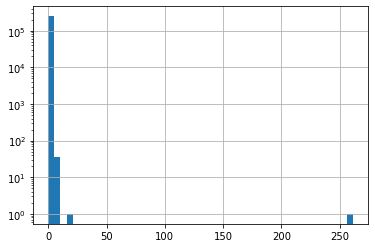

In [52]:
client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT'].hist(log=True,bins=50)

### Здесь, скорее всего тоже выброс. 

In [53]:
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT']>50),'AMT_REQ_CREDIT_BUREAU_QRT'] /= 10

In [54]:
client_profile_df[['DAYS_ON_LAST_JOB', 'OWN_CAR_AGE','FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE']].describe()

,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE
count,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000
mean,184.947625,12.030221,0.280244,0.057072,2.154025
std,381.537259,11.899404,0.449119,0.231981,0.911543
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.550685,5.000000,0.000000,0.000000,2.000000
50%,6.073973,9.000000,0.000000,0.000000,2.000000
75%,15.556164,15.000000,1.000000,0.000000,3.000000
max,1000.665753,69.000000,1.000000,1.000000,20.000000


In [55]:
client_profile_df.describe()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,1.235771e+08,0.341404,0.417624,1.685338e+05,5.993051e+05,27125.209585,1.509648,0.446794,0.020871,43.927289,...,2.154025,0.502122,5.141749e-01,0.510848,0.005492,0.005940,0.029604,0.231412,0.229876,1.642988
std,8.877722e+04,0.474182,0.722529,1.055593e+05,4.022720e+05,14503.930366,0.874491,0.257469,0.013827,11.948856,...,0.911543,0.210817,1.910938e-01,0.195054,0.077961,0.100443,0.190136,0.855523,0.580702,1.855330
min,1.234233e+08,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000000,0.000008,0.000290,20.517808,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,1.000000,0.147532,0.010006,34.013699,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,1.000000,0.639384,0.018850,43.134247,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,1.000000,2.025000e+05,8.086500e+05,34618.500000,2.000000,0.639384,0.028663,53.920548,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,1.000000,19.000000,1.350000e+07,4.050000e+06,230161.500000,4.000000,0.639384,0.072508,69.120548,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,26.100000,25.000000


<AxesSubplot:>

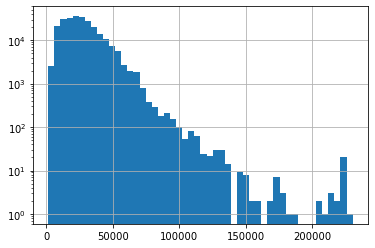

In [56]:
client_profile_df['AMOUNT_ANNUITY'].hist(log=True, bins=50)

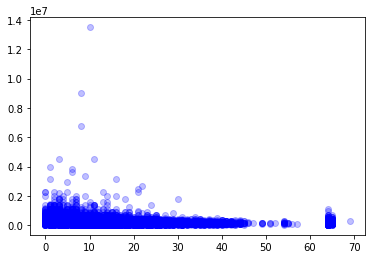

In [57]:
plt.scatter(client_profile_df['OWN_CAR_AGE'], client_profile_df['TOTAL_SALARY'], alpha=0.25, color="blue")

# BKI

In [58]:
bki_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/bki.csv')
bki_df.head(4)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN


In [59]:
bki_df.loc[(bki_df['DAYS_ENDDATE_FACT'].isna(), 'DAYS_ENDDATE_FACT')] = -999
bki_df.loc[(bki_df['DAYS_CREDIT'].isna(), 'DAYS_CREDIT')] = -999
bki_df.loc[(bki_df['DAYS_CREDIT_ENDDATE'].isna(), 'DAYS_CREDIT_ENDDATE')] = -999

bki_df.loc[(bki_df['AMT_CREDIT_SUM_DEBT'].isna(), 'AMT_CREDIT_SUM_DEBT')] = 0.0

In [60]:
bki_df = get_freq_encoder(bki_df, ['CREDIT_TYPE']) 

In [61]:
credit_curency = {'currency 1':0, 'currency 2':1, 'currency 3':2, 'currency 4':3}

In [62]:
bki_df['CREDIT_CURRENCY'] = bki_df['CREDIT_CURRENCY'].apply(lambda x: credit_curency[x])

In [63]:
bki_df['CREDIT_CURRENCY'].value_counts()

0    944492
1       647
2        91
3         4
Name: CREDIT_CURRENCY, dtype: int64

In [64]:
bki_df['CREDIT_TYPE'].value_counts()

0.728318    688431
0.235114    222238
0.016237     15348
0.010750     10161
0.007181      6788
0.001116      1055
0.000620       586
0.000317       300
0.000276       261
0.000033        31
0.000017        16
0.000015        14
0.000004         4
0.000001         1
Name: CREDIT_TYPE, dtype: int64

In [65]:
bki_df.describe()

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.00000,945234.000000,945234.000000,945234.000000,945234.000000,3.265570e+05,945234.000000,9.452290e+05,9.452340e+05,6.192670e+05,9.452340e+05,945234.000000,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,0.00089,1142.218231,0.769791,1645.353024,273.367870,3.784219e+03,0.006330,3.547738e+05,1.157534e+05,6.267718e+03,3.826128e+01,0.586159,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,0.03327,795.047305,35.173550,4587.831413,1126.921611,2.133823e+05,0.094857,1.078781e+06,5.893323e+05,4.528027e+04,5.156032e+03,0.236126,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.00000,0.000000,0.000000,-999.000000,-999.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000001,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,0.00000,474.000000,0.000000,298.000000,-999.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.235114,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,0.00000,987.000000,0.000000,798.000000,352.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.728318,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,0.00000,1666.000000,0.000000,1452.000000,1090.000000,0.000000e+00,0.000000,3.150000e+05,1.125000e+03,0.000000e+00,0.000000e+00,0.728318,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,3.00000,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,0.728318,41943.000000,1.184534e+08


In [66]:
# если кредиту уже активный  и DAYS_CREDIT < DAYS_CREDIT_ENDDATE значит время платежа еще не пришло.
# DAYS_ENDDATE_FACT = NAN
# если DAYS_CREDIT > DAYS_CREDIT_ENDDATE	и DAYS_ENDDATE_FACT = NAN значит у нас просрочка по платежу. 
# DAYS_CREDIT - DAYS_CREDIT_ENDDATE

# значит по текущему кредит есть задолжности в погашении.

In [67]:
bki_dic = {
    'APPLICATION_NUMBER':[],
     'active_credits':[],
     'closed_credits':[],
     'sold_credits':[],
     'bad_debt':[],
     'credit_problems':[], 
     'credits_count':[],
     'curency_mean':[],
     'credit_type_mean':[],
    #  ------------
     'active_delay':[], 
     'closed_delay':[], 
     'credit_debt':[], 
}

def creat_bki_features(app_number):
    bki = bki_df.loc[(bki_df['APPLICATION_NUMBER']==app_number)]

    credit_problems = np.sum(bki['CNT_CREDIT_PROLONG'])

    active_credits = 0
    closed_credits = 0
    sold_credits = 0
    bad_debt = 0
    closed_delay = 0  # просрочки по закрытым кредитам в днях.
    active_delay = 0  # прострочки по активным кредитам кредитам в днях
    credit_debt = 0   # сумма долга перед банком по закрытым кредитам.
    active_credits = 0
    closed_credits = 0
    credits_count = len(bki)
    active=[]
    closed=[]

    for ind in range(credits_count):
        line = bki.iloc[ind]
        
        if line['CREDIT_ACTIVE']=='Active':

            active_credits+=1
            if (line['DAYS_CREDIT_ENDDATE']==-999.0) | (line['DAYS_CREDIT']==-999.0):
                 active.append(0.0)
            elif (line['DAYS_CREDIT'] > line['DAYS_CREDIT_ENDDATE']) & (line['DAYS_ENDDATE_FACT']==-999.0):
                # active_delay+=line['DAYS_CREDIT']-line['DAYS_CREDIT_ENDDATE']  
                active.append(line['DAYS_CREDIT']-line['DAYS_CREDIT_ENDDATE'])
            elif (line['DAYS_CREDIT_ENDDATE'] > line['DAYS_CREDIT']) & (line['DAYS_ENDDATE_FACT']> line['DAYS_CREDIT_ENDDATE']):
                # active_delay+=line['DAYS_ENDDATE_FACT'] - line['DAYS_CREDIT_ENDDATE']
                active.append(line['DAYS_ENDDATE_FACT'] - line['DAYS_CREDIT_ENDDATE'])

        if line['CREDIT_ACTIVE']=='Closed':
            closed_credits+=1
            if (line['DAYS_CREDIT_ENDDATE'] > line['DAYS_CREDIT']):
                closed.append(line['DAYS_CREDIT_ENDDATE'] + line['DAYS_CREDIT'])

            credit_debt += line['AMT_CREDIT_SUM_DEBT']
   
        if line['CREDIT_ACTIVE']== 'Sold':
            sold_credits +=1
        
        if line['CREDIT_ACTIVE']== 'Bad debt':
            bad_debt +=1  
        
    # active_credits, closed_credits, sold_credits, bad_debt  
    credit_debt = credit_debt if credit_debt > 0 else 0
    
    credits_count = len(bki)
    curency_mean = np.mean(bki['CREDIT_CURRENCY'])
    credit_type_mean = np.mean(bki['CREDIT_TYPE'])
    bki_dic['APPLICATION_NUMBER'].append(app_number)
    bki_dic['active_credits'].append(active_credits)
    bki_dic['closed_credits'].append(closed_credits)
    bki_dic['sold_credits'].append(sold_credits)
    bki_dic['bad_debt'].append(bad_debt)
    bki_dic['credit_problems'].append(credit_problems)
    bki_dic['credits_count'].append(credits_count)
    bki_dic['curency_mean'].append(curency_mean)
    bki_dic['credit_type_mean'].append(credit_type_mean)
    bki_dic['active_delay'].append(active_delay) 
    bki_dic['closed_delay'].append(closed_delay)
    bki_dic['credit_debt'].append(credit_debt) 
    
# Посчитать максимальную сумму кредита. 
# Максимальную сумму закрытого кредита сумму кредита.
# bki_unic = bki_df['APPLICATION_NUMBER'].unique()

# for app_number in tqdm(bki_unic):
#     creat_bki_features(app_number)

# bki_statistic = pd.DataFrame(bki_dic)
# bki_statistic.to_csv('bki_statistic.csv',index=False)


# Рассоментировать, чтобы загрузить из файла!!!

bki_statistic = pd.read_csv('bki_statistic.csv')
# np.max(bki_statistic['APPLICATION_NUMBER'].value_counts().values)
bki_statistic.head(5)

,APPLICATION_NUMBER,active_credits,closed_credits,sold_credits,bad_debt,credit_problems,credits_count,curency_mean,credit_type_mean,active_delay,closed_delay,credit_debt
0,123538884,2,1,0,0,0,3,0.0,0.728318,0,0,0.0
1,123436670,5,3,0,0,0,8,0.0,0.420066,0,0,0.0
2,123589020,0,7,0,0,0,7,0.0,0.728318,0,0,0.0
3,123494590,2,1,0,0,0,3,0.0,0.563917,0,0,0.0
4,123446603,1,0,0,0,0,1,0.0,0.235114,0,0,0.0


# Payments

In [68]:
payments_df.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,1.236018e+08,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.027412e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,1.234233e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,1.235130e+08,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.236020e+08,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.236910e+08,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.237796e+08,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


In [69]:
# Создадами признак. к-во платежей. среднее просрочки по платежам. 
# к-во активных кредитов / к-во кредитов по которым производились выплаты.
# если просрочка < 0, то просрочки нет.

In [70]:
payments_dic = {
        'APPLICATION_NUMBER':[],
        'payments_credits_count':[],
        'payments_count':[],
        'mean_dalay':[]
}


def creat_payments_features(number):
    payments = payments_df.loc[(payments_df['APPLICATION_NUMBER']==number)] #123590329
    
    credit_pay_count = len(payments['PREV_APPLICATION_NUMBER'].unique()) # к-во кредитов по которым клиент платит.
    
    payments_count = len(payments['PREV_APPLICATION_NUMBER']) 

    # к-во просрочек по платежам.
    days_delay=[]
    delays = 0 # к-во просрочек
    for index in range(payments_count):
        entry_payment = payments.iloc[index]['DAYS_ENTRY_PAYMENT']
        instalment = payments.iloc[index]['DAYS_INSTALMENT'] 
        if entry_payment > instalment:
            days_delay.append(entry_payment - instalment)
            delays+= 1
        else:
         days_delay.append(0.0)

    mean_dalay = np.sum(days_delay)/payments_count * delays # Будем считать, что это средняя просрочка.
    
    payments_dic['APPLICATION_NUMBER'].append(number)
    payments_dic['payments_credits_count'].append(credit_pay_count)
    payments_dic['payments_count'].append(payments_count)
    payments_dic['mean_dalay'].append(mean_dalay)

In [71]:
# payments_unic = payments_df['APPLICATION_NUMBER'].unique()

# for number in tqdm(payments_unic):
#     creat_payments_features(number)

# payments_statistic = pd.DataFrame(payments_dic)
# payments_statistic.to_csv('payments_statistic.csv',index=False)

payments_statistic = pd.read_csv('payments_statistic.csv')
payments_statistic.head(5)

,APPLICATION_NUMBER,payments_credits_count,payments_count,mean_dalay
0,123664960,1,1,13.000000
1,123497205,4,17,14.000000
2,123749925,1,2,28.000000
3,123550846,2,9,7.111111
4,123562174,2,14,5.357143


## Объединим все интересующие нас таблицы в одну. создадим новые признаки.

Основная проблема в данной задаче состоит в том, что не для всех люей существоет запись в таблице профиля пользователя. Такое ощущение, будто  их специально удалили. так как и в таблице БКИ и  app_history записи для всех пользователей присутствуют. 
И это создает проблемму. т.к. для этих пользователей предсказать вероятность возврата кредита оказывается достаточно сложно. 
Для того чтобы это исправить заполним пропуски наиболее часто встречающимися значениями в категориях.



In [72]:
def df_prepare(source_df, join_type ='left', is_fulling_delay=False, is_bki_merge=False, is_payment_merge=False):
    source_df = source_df.copy(deep=True)
    # client_profile_df_1 = category_to_digit(client_profile_df, ['EDUCATION_LEVEL', 'FAMILY_STATUS'])
    client_profile_df_1 = client_profile_df.copy(deep=True) # get_freq_encoder(client_profile_df, ['EDUCATION_LEVEL', 'FAMILY_STATUS'])
    
    

    df = source_df.merge(client_profile_df_1, how=join_type, on='APPLICATION_NUMBER')
    df = get_freq_encoder(df, ['NAME_CONTRACT_TYPE'])
    #---------------------------------------------------------------------------------------
    if is_bki_merge:
        df = df.merge(bki_statistic, how=join_type ,on='APPLICATION_NUMBER')
    #---------------------------------------------------------------------------------------    
    if is_payment_merge:
        df = df.merge(payments_statistic, how=join_type ,on='APPLICATION_NUMBER')
        df.loc[(df['payments_credits_count'].isna(), 'payments_credits_count')] = 0.0
        df.loc[(df['payments_count'].isna(), 'payments_count')] = 0.0
        df.loc[(df['mean_dalay'].isna(), 'mean_dalay')] = 0.0


    # Заполняем пропуски.
    #--------------------------------------------------------------------------------------
    # заполним пропуски в таблице наиболее часто встречающимися значениями.
    if is_fulling_delay:
        features = df.columns.values
        # features = features[:-5]
        for feature in features:
            values = df[feature].value_counts()
            most_popular  = values.index[0]
            # len_values = len(values)
            df.loc[(df[feature].isna()),feature] = most_popular
 
    #--------------------------------------------------------------------------------------
    # Создание новых признаков

    df["EXTERNAL_SCORING_RATING"] = (df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"])
    df["EXTERNAL_SCORING_RATING_SUM"] = (df["EXTERNAL_SCORING_RATING_1"] + df["EXTERNAL_SCORING_RATING_2"] + df["EXTERNAL_SCORING_RATING_3"])
 
    df["CREDIT_AGE_LONG"] = df["AMOUNT_CREDIT"]/(df["AMOUNT_ANNUITY"]*12)

    df['SOLVENCY'] = df['TOTAL_SALARY']/df["AMOUNT_ANNUITY"] 

    # Возраст человека полсе того как кредит будет выплачен.
    df['AGE_AFTER'] = df['AGE'] + df["CREDIT_AGE_LONG"] 

    # Судя по всему, к-во запросов в кредитное бюро по клиенту за день, неделю, месяц, квартал как-то коррелирует с суммой кредита.
    # Поэтому, эти показатели наверное имее смысл просуммировать с разными весами.
    df['AMT_REQ_CREDIT_BUREAU'] = (1*df['AMT_REQ_CREDIT_BUREAU_HOUR']+
                                2*df['AMT_REQ_CREDIT_BUREAU_DAY']+
                                3*df['AMT_REQ_CREDIT_BUREAU_WEEK']+
                                4*df['AMT_REQ_CREDIT_BUREAU_MON']+
                                6*df['AMT_REQ_CREDIT_BUREAU_QRT']+
                                7*df['AMT_REQ_CREDIT_BUREAU_YEAR'])

    if (is_bki_merge & is_payment_merge):
        df['active_credits_payment']= df['active_credits']/df['payments_credits_count'] # по какому к-ву кредитов из активных на текущий момент клиент уже произвел выплаты.
        df.loc[(df['active_credits']==0),'active_credits_payment'] = df.loc[(df['active_credits']==0),'payments_credits_count']
        # if is_fulling_delay:
        values = df['active_credits_payment'].value_counts()
        most_popular  = values.index[0]
        # len_values = len(values)
        df.loc[(df['active_credits_payment'].isna()),'active_credits_payment'] = most_popular


    return df

# Обучение модели.

In [73]:
# Функция для выполнения балансировки классов.

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [74]:
df = df_prepare(train_df,join_type='left')

In [75]:
df.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_RATING,EXTERNAL_SCORING_RATING_SUM,CREDIT_AGE_LONG,SOLVENCY,AGE_AFTER,AMT_REQ_CREDIT_BUREAU
0,123687442,0,0.904245,1.0,1.0,157500.0,855000.0,25128.0,1.0,0.639384,...,1.0,0.0,0.0,2.0,0.324353,2.063268,2.835482,6.267908,45.925893,17.0
1,123597908,1,0.904245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,0.904245,0.0,0.0,135000.0,1006920.0,42660.0,3.0,0.639384,...,0.0,7.0,0.0,4.0,NaN,NaN,1.966948,3.164557,61.027222,56.0


Заполним пропукски в данных.

<AxesSubplot:>

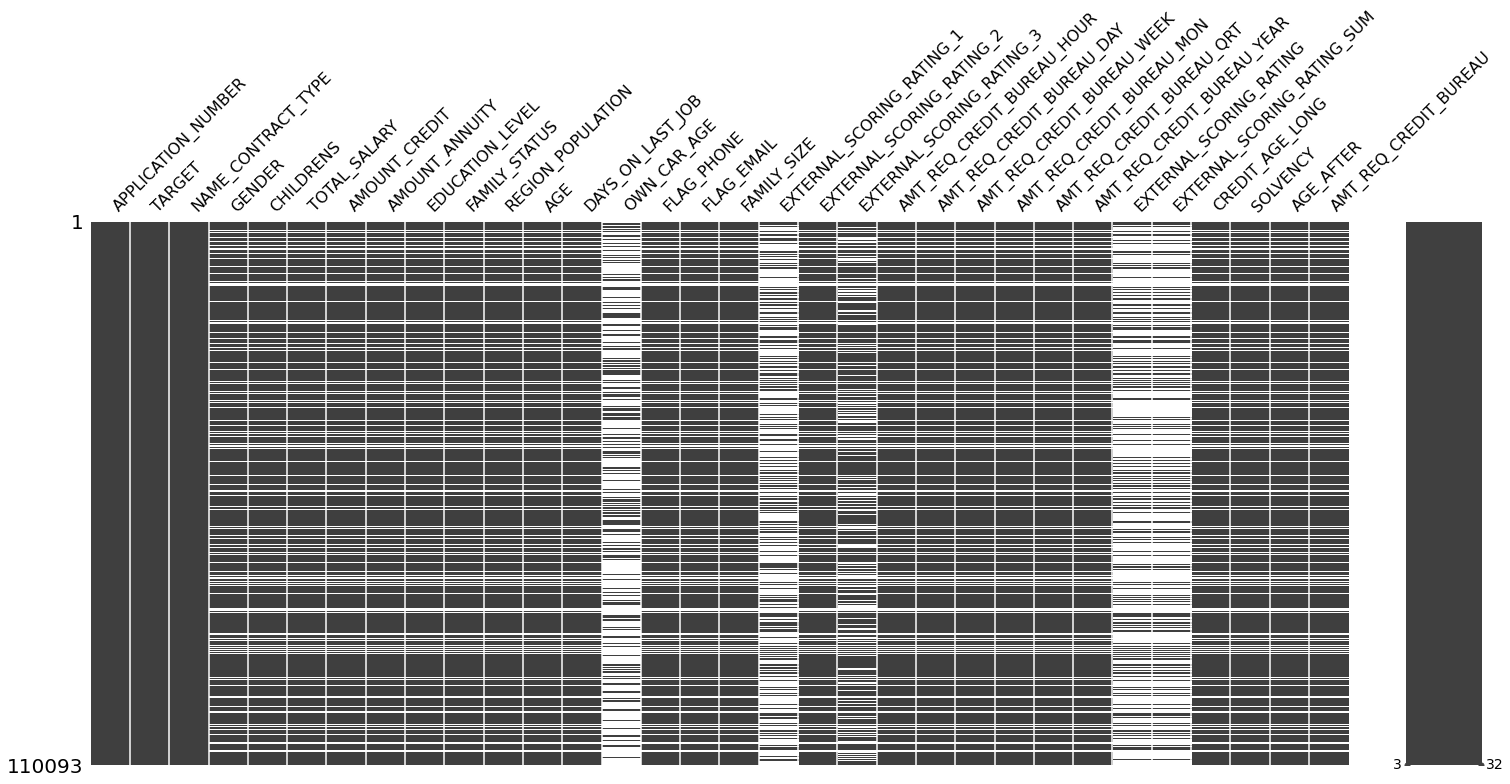

In [76]:
msno.matrix(df)

In [77]:
df = df_prepare(train_df,join_type='left',is_fulling_delay=True)

<AxesSubplot:>

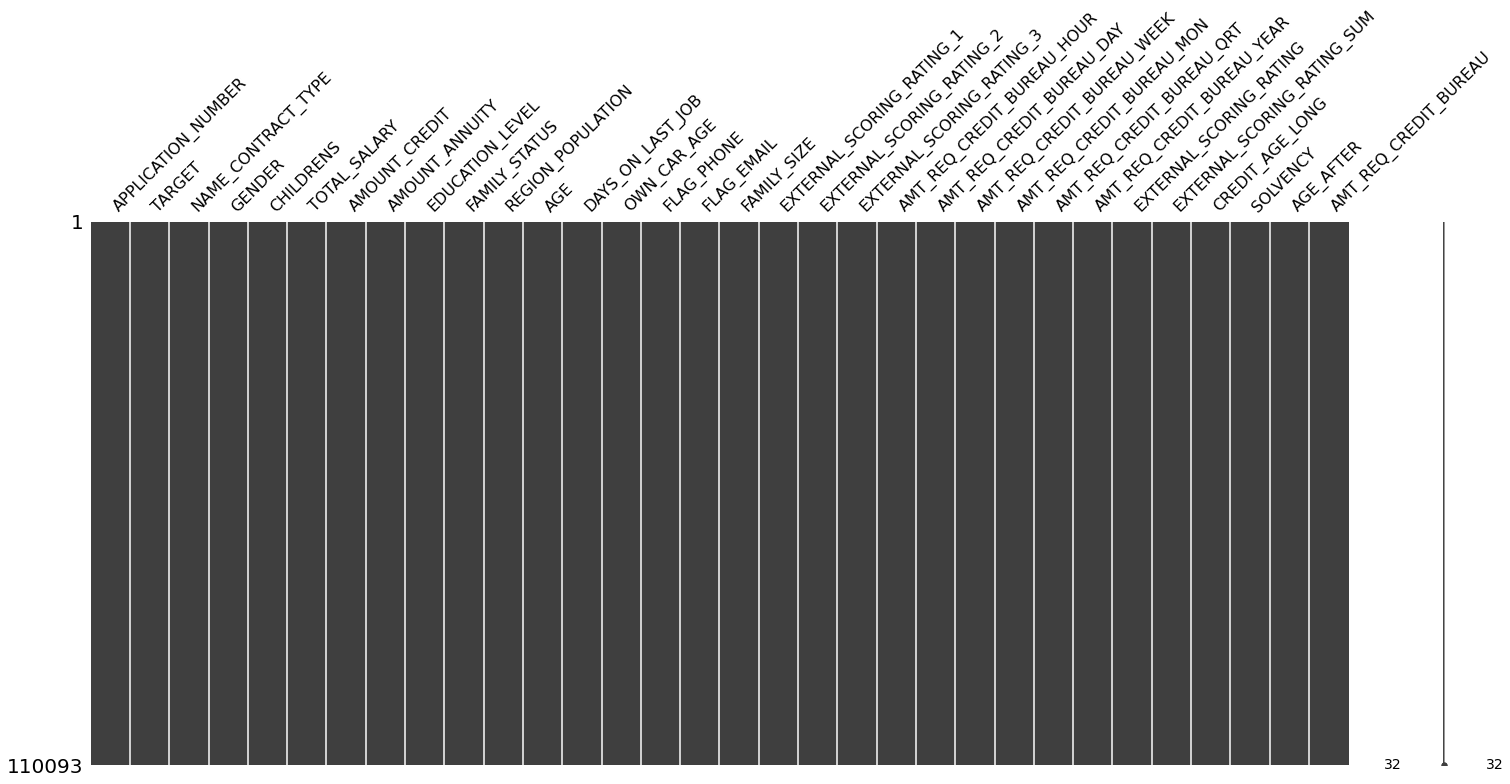

In [78]:
msno.matrix(df)

In [79]:
# Коэфициент для балансировки классов.

disbalance = df["TARGET"].value_counts()[0] / df["TARGET"].value_counts()[1]
disbalance

11.37417106889963

In [80]:
lgbm_model = lgb.LGBMClassifier(
        # class_weights=[1, disbalance],
        boosting_type="gbdt",
        objective ="binary",
        metric = "auc",
        learning_rate = 0.1,
        n_estimators = 10000,
        reg_lambda = 50,
        max_depth = 4,
        random_state = 1,
        early_stopping_round=500
       )

In [81]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=21,
# Выполнить балансировку установив параметр weight = [1,3.6] для уменьшения дисбаланса классов.
                                    # class_weights=[1, disbalance],
                                    score_function='L2',
                                    depth = 7,
                                    eval_metric='AUC',
                                    use_best_model=True,
                                    boosting_type = 'Ordered', #  / Plain 
                                    l2_leaf_reg = 3, # -- регуляризация. 3.0 = по умолчанию. 
                                    # eta = 0.5,
                                    learning_rate=0.01,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=10000,
                                    early_stopping_rounds=500,
                                    # verbose=True
                                )

### Выберем счетание таблиц и фитчей, которые дают наилучший результат.

In [82]:
model_index = 0
results_dic = { 'model_name':[],
                'train-score': [],
                'val-score': [],
                'test-score': []
              }

In [83]:
def test_data_prediction(model_name, estimators: object, is_fulling_delay=False, is_bki_merge=False, is_payment_merge=False):
    test_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/test.csv')
    test_df.head(4)

    test = df_prepare(test_df, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

    final_id = test['APPLICATION_NUMBER']
    x_data = test.drop(["APPLICATION_NUMBER"], axis=1)

  # Прогноз
    y_pred = np.zeros(x_data.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(x_data)[:, 1]
        
    y_pred=y_pred/len(estimators)

    df_final = pd.DataFrame({'APPLICATION_NUMBER':final_id, 'TARGET':list(y_pred)})
    
    # model_index+=1
    df_final.to_csv(f'prediction_{model_name}.csv', index=False, encoding='utf-8')

In [84]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):    
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        

        estimator.fit(x_train, y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      verbose=False
                      )
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        # print(y_train_pred.shape, y_train.shape)
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [85]:
def evalute_model(df, estimator: object, metric: callable, model_name='',  is_KFold = False, is_balanced=True):

 # Разделим выборки на тренировчную, тестовую и валидационную.
    x_train, x_test = train_test_split(df.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), train_size=0.60, shuffle=True, random_state=1)
    y_train, y_test = train_test_split(df["TARGET"], train_size=0.60, shuffle=True, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

    x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=True, random_state=1,)
    y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=True, random_state=1,)

    if is_balanced:
      df_for_balancing = pd.concat([x_train, y_train], axis=1)
      df_balanced = balance_df_by_target(df_for_balancing, "TARGET", method='over')
          
      x_train = df_balanced.drop(columns="TARGET")
      y_train = df_balanced["TARGET"]

    estimator = estimator
    
    if is_KFold:
#-------------------------------------
        x_train = pd.concat([x_train, x_val], axis=0,ignore_index=True)
        y_train = pd.concat([y_train, y_val], axis=0,ignore_index=True)

        cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

        estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
        x_train, y_train, estimator, metric=metric, cv_strategy=cv_strategy )

        ## Прогноз
        #----------------------------------
        y_pred = np.zeros(x_train.shape[0])

        for estimator in estimators:
            y_pred += estimator.predict_proba(x_train)[:,1]

        y_pred = y_pred/cv_strategy.n_splits

        train_score = metric(y_train, y_pred)
        #----------------------------------
        y_pred = np.zeros(x_val.shape[0])

        for estimator in estimators:
            y_pred += estimator.predict_proba(x_val)[:,1]

        y_pred = y_pred/cv_strategy.n_splits

        val_score = metric(y_val, y_pred)
        #-----------------------------------
        y_pred = np.zeros(x_test.shape[0])

        for estimator in estimators:
            y_pred += estimator.predict_proba(x_test)[:,1]

        y_pred = y_pred/cv_strategy.n_splits

        test_score = metric(y_test, y_pred)
    
        estimator = estimators
#-------------------------------------
    else:
#-------------------------------------
        estimator.fit(
            X=x_train,
            y=y_train,
            eval_set=[(x_train, y_train), (x_val, y_val)],
            verbose=100
        )
        train_score = metric(y_train, estimator.predict_proba(x_train)[:,1])
        val_score = metric(y_val, estimator.predict_proba(x_val)[:,1])
        test_score = metric(y_test, estimator.predict_proba(x_test)[:,1])

    clear_output(wait=True) # Очищаем поле вывода.   
         
    print(f"\r\n Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

#-------------------------------------
    # print(f'Test predict = {test_score:.5}')
    results_dic['model_name'].append(model_name)
    results_dic['train-score'].append(train_score)
    results_dic['val-score'].append(val_score)
    results_dic['test-score'].append(test_score)
    return estimator

# Построим несколько вариантов моделей, чтобы определеить какая из них даст лучший результат.

# LightGBM

In [71]:
model_name = 'lgbm_model_1'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score, model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.77, Val-score: 0.737, Test-score: 0.724


In [72]:
model_name = 'lgbm_model_2';  is_bki_merge=True; is_payment_merge=False; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.778, Val-score: 0.736, Test-score: 0.726


In [73]:
model_name = 'lgbm_model_3';  is_bki_merge=False; is_payment_merge=True; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay, is_bki_merge, is_payment_merge)


 Train-score: 0.755, Val-score: 0.737, Test-score: 0.724


In [74]:
model_name = 'lgbm_model_4';  is_bki_merge=True; is_payment_merge=True; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.759, Val-score: 0.736, Test-score: 0.724


## LightGBM с заполнением пропусков.

In [75]:
model_name = 'lgbm_model_5';  is_bki_merge=False; is_payment_merge=False; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left' , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.762, Val-score: 0.737, Test-score: 0.726


In [76]:
model_name = 'lgbm_model_6';  is_bki_merge=True; is_payment_merge=False; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.763, Val-score: 0.738, Test-score: 0.725


In [77]:
model_name = 'lgbm_model_7';  is_bki_merge=False; is_payment_merge=True; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left' , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator] , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.765, Val-score: 0.738, Test-score: 0.725


In [78]:
model_name = 'lgbm_model_8';  is_bki_merge=True; is_payment_merge=True; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.762, Val-score: 0.738, Test-score: 0.724


## LightGBM KFold

In [101]:
model_name = 'lgbm_model_9';  is_bki_merge=False; is_payment_merge=False; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df, join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.765, Val-score: 0.772, Test-score: 0.726


In [102]:
model_name = 'lgbm_model_10';  is_bki_merge=True; is_payment_merge=False; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.757, Val-score: 0.765, Test-score: 0.724


In [104]:
model_name = 'lgbm_model_11';  is_bki_merge=False; is_payment_merge=True; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.753, Val-score: 0.761, Test-score: 0.724


In [105]:
model_name = 'lgbm_model_12'; is_bki_merge=True; is_payment_merge=True; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.76, Val-score: 0.768, Test-score: 0.725


## LightGBM KFold с заполнением пропусков.

In [106]:
model_name = 'lgbm_model_13'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.761, Val-score: 0.769, Test-score: 0.727


In [107]:
model_name = 'lgbm_model_14'; is_bki_merge=True; is_payment_merge=False; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.758, Val-score: 0.765, Test-score: 0.727


In [108]:
model_name = 'lgbm_model_15'; is_bki_merge=False; is_payment_merge=True; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.756, Val-score: 0.763, Test-score: 0.726


In [109]:
model_name = 'lgbm_model_16'; is_bki_merge=True; is_payment_merge=True; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, lgbm_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.756, Val-score: 0.764, Test-score: 0.727


# CATBOOST

In [110]:
model_name = 'catb_model_1'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score, model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_predictis_fulling_delay, is_bki_merge, is_payment_mergeion(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.768, Val-score: 0.736, Test-score: 0.723


In [111]:
model_name = 'catb_model_2';  is_bki_merge=True; is_payment_merge=False; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.767, Val-score: 0.735, Test-score: 0.724


In [112]:
model_name = 'catb_model_3';  is_bki_merge=False; is_payment_merge=True; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.779, Val-score: 0.736, Test-score: 0.725


In [113]:
model_name = 'catb_model_4';  is_bki_merge=True; is_payment_merge=True; is_fulling_delay=False; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.783, Val-score: 0.736, Test-score: 0.724


## CATBOOST с заполнением пропусков.

In [115]:
model_name = 'catb_model_5'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left' , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.808, Val-score: 0.737, Test-score: 0.726


In [116]:
model_name = 'catb_model_6'; is_bki_merge=True; is_payment_merge=False; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.795, Val-score: 0.738, Test-score: 0.726


In [117]:
model_name = 'catb_model_7'; is_bki_merge=False; is_payment_merge=True; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left' , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator] , is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.798, Val-score: 0.736, Test-score: 0.725


In [118]:
model_name = 'catb_model_8'; is_bki_merge=True; is_payment_merge=True; is_fulling_delay=True; is_KFold = False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, [estimator], is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.807, Val-score: 0.737, Test-score: 0.726


## CATBOOST KFold

In [120]:
model_name = 'catb_model_9'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.77, Val-score: 0.777, Test-score: 0.729


In [121]:
model_name = 'catb_model_10'; is_bki_merge=True; is_payment_merge=False; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.771, Val-score: 0.777, Test-score: 0.728


In [122]:
model_name = 'catb_model_11'; is_bki_merge=False; is_payment_merge=True; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.777, Val-score: 0.784, Test-score: 0.727


In [123]:
model_name = 'catb_model_12'; is_bki_merge=True; is_payment_merge=True; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.751, Val-score: 0.759, Test-score: 0.725


## CATBOOST KFold с заполнением пропусков.

In [125]:
model_name = 'catb_model_13'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.77, Val-score: 0.775, Test-score: 0.725


In [126]:
model_name = 'catb_model_14'; is_bki_merge=True; is_payment_merge=False; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.758, Val-score: 0.765, Test-score: 0.723


In [127]:
model_name = 'catb_model_15'; is_bki_merge=False; is_payment_merge=True; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.754, Val-score: 0.762, Test-score: 0.723


In [128]:
model_name = 'catb_model_16'; is_bki_merge=True; is_payment_merge=True; is_fulling_delay=True; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.78, Val-score: 0.786, Test-score: 0.726


## Сводная таблица результатов.

In [129]:
pd.DataFrame(results_dic)

,model_name,train-score,val-score,test-score
0,lgbm_model_1,0.724119,0.724119,0.724119
1,lgbm_model_2,0.726223,0.726223,0.726223
2,lgbm_model_3,0.723521,0.723521,0.723521
3,lgbm_model_4,0.723805,0.723805,0.723805
4,lgbm_model_5,0.725688,0.725688,0.725688
5,lgbm_model_6,0.724505,0.724505,0.724505
6,lgbm_model_7,0.724879,0.724879,0.724879
7,lgbm_model_8,0.724236,0.724236,0.724236
8,lgbm_model_9,0.725687,0.725687,0.725687
9,lgbm_model_9,0.725687,0.725687,0.725687


### Опеределим измерение на котором удалось достичь максимального качества.

In [130]:
result_df=pd.DataFrame(results_dic)

In [132]:
result_df.sort_values(by='test-score', ignore_index=True)

,model_name,train-score,val-score,test-score
0,catb_model_15,0.722628,0.722628,0.722628
1,catb_model_14,0.723436,0.723436,0.723436
2,catb_model_1,0.723478,0.723478,0.723478
3,lgbm_model_3,0.723521,0.723521,0.723521
4,lgbm_model_4,0.723805,0.723805,0.723805
5,lgbm_model_10,0.723821,0.723821,0.723821
6,catb_model_2,0.724113,0.724113,0.724113
7,lgbm_model_1,0.724119,0.724119,0.724119
8,lgbm_model_8,0.724236,0.724236,0.724236
9,lgbm_model_11,0.724443,0.724443,0.724443


## Попробуем еще немного повысить к-во предсказания, добавив балансироку классов.

In [95]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=21,
                                    # class_weights=[1, disbalance], # <== ^_^
                                    score_function='L2',
                                    depth = 7,
                                    eval_metric='AUC',
                                    use_best_model=True,
                                    boosting_type = 'Ordered', #  / Plain 
                                    l2_leaf_reg = 3, # -- регуляризация. 3.0 = по умолчанию. 
                                    # eta = 0.5,
                                    learning_rate=0.01,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=10000,
                                    early_stopping_rounds=500,
                                    # verbose=True
                                )

In [148]:
model_name = 'catb_model_25'; is_bki_merge=False; is_payment_merge=False; is_fulling_delay=False; is_KFold = True

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)

estimator = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)  # <== ^_^

test_data_prediction(model_name, estimator, is_fulling_delay=is_fulling_delay, is_bki_merge=is_bki_merge, is_payment_merge=is_payment_merge)


 Train-score: 0.77, Val-score: 0.771, Test-score: 0.73
